### Natural Language Processing and Sentiment Analysis for Support Desk Comment Review


### Student Names: Trang Nguyen,Hassaan Saleh,Surya Srirangarajan,Kathy Thompson,Jing Zhu


# Install Packages and Libraries

In [129]:
!pip install wordcloud

In [130]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [131]:
!pip install spacy

In [132]:
!pip3 install vpython

In [133]:
import vpython

In [134]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [135]:
#Import libraries
import pandas as pd   # for importing & transforming data
import numpy as np # an essential python module
import re   # for regular expressions
import seaborn as sn    # for charts
import seaborn as sns    # for charts
import matplotlib.pyplot as plt   # for wordclouds & charts
import nltk
import nltk.corpus
from wordcloud import WordCloud,STOPWORDS
from collections import Counter
import itertools
from io import StringIO  # python3 (or BytesIO for python2)
import boto3

In [136]:
import seaborn as sns

In [137]:
import plotly.express as px

In [138]:
# Import NLTK Library
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 1. Data Loading and Exploratory Analysis

In [139]:
# Read file from S3 Bucket
data_file = 's3://daen690-goodfellas-data/GMU_CSD_Data1.csv'
df_alldata = pd.read_csv(data_file)
# Perform some preminalry analysis
print('Number of instances = %d' % (df_alldata.shape[0]))
print('Number of attributes = %d' % (df_alldata.shape[1]))
df_alldata.head(20)

Number of instances = 97934
Number of attributes = 5


Unnamed: 0      Instance                 Question    String Value  \
0            0  AINST0199202           Issue Resolved             Yes   
1            1  AINST0199202                 Feedback             NaN   
2            2  AINST0199202        Time Satisfaction  Very Satisfied   
3            3  AINST0199202       Agent Satisfaction  Very Satisfied   
4            4  AINST0199202  Management Satisfaction  Very Satisfied   
5            5  AINST0199209  Management Satisfaction       Satisfied   
6            6  AINST0199209       Agent Satisfaction       Satisfied   
7            7  AINST0199209           Issue Resolved             Yes   
8            8  AINST0199209        Time Satisfaction       Satisfied   
9            9  AINST0199209                 Feedback             NaN   
10          10  AINST0199414           Issue Resolved             Yes   
11          11  AINST0199414        Time Satisfaction  Very Satisfied   
12          12  AINST0199414                 Feedback             NaN   
13          13  AINST0199414       Agent Satisfaction  Very Satisfied   
14          14  AINST0199414  Management Satisfaction  Very Satisfied   
15          15  AINST0199906       Agent Satisfaction       Satisfied   
16          16  AINST0199906                 Feedback             NaN   
17          17  AINST0199906        Time Satisfaction       Satisfied   
18          18  AINST0199906           Issue Resolved             Yes   
19          19  AINST0199906  Management Satisfaction       Satisfied   

           Created  
0   10/1/2019 4:52  
1   10/1/2019 4:52  
2   10/1/2019 4:52  
3   10/1/2019 4:52  
4   10/1/2019 4:52  
5   10/1/2019 3:41  
6   10/1/2019 3:41  
7   10/1/2019 3:41  
8   10/1/2019 3:41  
9   10/1/2019 3:41  
10  10/1/2019 7:00  
11  10/1/2019 7:00  
12  10/1/2019 7:00  
13  10/1/2019 7:00  
14  10/1/2019 7:00  
15  10/2/2019 1:54  
16  10/2/2019 1:54  
17  10/2/2019 1:54  
18  10/2/2019 1:54  
19  10/2/2019 1:54

There are 97934 rows in total; Number of Attributes: 5 attribute.

1.1 Missing Values

# 2. Data Cleaning and Transformation

In [140]:
# Only take selected columns
df_clean = df_alldata[['Unnamed: 0','Instance','Question','String Value','Created']]
df_clean.shape


(97934, 5)

In [141]:
df_clean.head()

Unnamed: 0      Instance                 Question    String Value  \
0           0  AINST0199202           Issue Resolved             Yes   
1           1  AINST0199202                 Feedback             NaN   
2           2  AINST0199202        Time Satisfaction  Very Satisfied   
3           3  AINST0199202       Agent Satisfaction  Very Satisfied   
4           4  AINST0199202  Management Satisfaction  Very Satisfied   

          Created  
0  10/1/2019 4:52  
1  10/1/2019 4:52  
2  10/1/2019 4:52  
3  10/1/2019 4:52  
4  10/1/2019 4:52

In [142]:
# Tranpose values of 'Question' column into seperate columns. This removes duplicate Instance. 
df_clean = df_clean.pivot(index = ('Instance','Created'), columns = 'Question', values = 'String Value')
df_clean.reset_index(inplace = True)
df_clean.head(20)
df_clean['Issue Resolved'].value_counts()

Yes    16181
No      2797
Name: Issue Resolved, dtype: int64

In [143]:
df_clean.head()

Question      Instance         Created Agent Satisfaction Feedback  \
0         AINST0199202  10/1/2019 4:52     Very Satisfied      NaN   
1         AINST0199209  10/1/2019 3:41          Satisfied      NaN   
2         AINST0199414  10/1/2019 7:00     Very Satisfied      NaN   
3         AINST0199906  10/2/2019 1:54          Satisfied      NaN   
4         AINST0199999  10/1/2019 8:42                NaN      NaN   

Question Issue Resolved Management Comment Management Satisfaction  \
0                   Yes                NaN          Very Satisfied   
1                   Yes                NaN               Satisfied   
2                   Yes                NaN          Very Satisfied   
3                   Yes                NaN               Satisfied   
4                    No                NaN                     NaN   

Question Time Satisfaction  \
0           Very Satisfied   
1                Satisfied   
2           Very Satisfied   
3                Satisfied   
4                      NaN   

Question                                                                                                                                                                           Unresolved Comment  
0                                                                                                                                                                                                 NaN  
1                                                                                                                                                                                                 NaN  
2                                                                                                                                                                                                 NaN  
3                                                                                                                                                                                                 NaN  
4         On Sunday 9/29 I received another reminder that my password was expiring "in 1 day" even  after you updated the system to reflect my most recent password change of 9/16/19. Please advise.

# 3. Breaking Created into Year, Month and Quarter

In [144]:
# Creating new columns for Year, Month and Quarter from existing columnn 'Created'
df_clean['year'] = pd.DatetimeIndex(df_clean['Created']).year
df_clean['Month'] = pd.DatetimeIndex(df_clean['Created']).month
df_clean['quarter'] = pd.to_datetime(df_clean['Created']).dt.quarter
df_clean.shape


(19065, 12)

In [145]:
df_clean

Question      Instance          Created Agent Satisfaction Feedback  \
0         AINST0199202   10/1/2019 4:52     Very Satisfied      NaN   
1         AINST0199209   10/1/2019 3:41          Satisfied      NaN   
2         AINST0199414   10/1/2019 7:00     Very Satisfied      NaN   
3         AINST0199906   10/2/2019 1:54          Satisfied      NaN   
4         AINST0199999   10/1/2019 8:42                NaN      NaN   
...                ...              ...                ...      ...   
19060     AINST0386193  1/31/2021 13:09     Very Satisfied      NaN   
19061     AINST0386381  1/31/2021 22:24          Satisfied      NaN   
19062     AINST0386388  1/31/2021 21:11     Very Satisfied      NaN   
19063     AINST0386409  1/31/2021 23:21     Very Satisfied      NaN   
19064     AINST0386413  1/31/2021 23:38                NaN      NaN   

Question Issue Resolved Management Comment Management Satisfaction  \
0                   Yes                NaN          Very Satisfied   
1                   Yes                NaN               Satisfied   
2                   Yes                NaN          Very Satisfied   
3                   Yes                NaN               Satisfied   
4                    No                NaN                     NaN   
...                 ...                ...                     ...   
19060               Yes                NaN          Very Satisfied   
19061               Yes                NaN               Satisfied   
19062               Yes                NaN          Very Satisfied   
19063               Yes                NaN          Very Satisfied   
19064                No                NaN                     NaN   

Question Time Satisfaction  \
0           Very Satisfied   
1                Satisfied   
2           Very Satisfied   
3                Satisfied   
4                      NaN   
...                    ...   
19060       Very Satisfied   
19061            Satisfied   
19062       Very Satisfied   
19063       Very Satisfied   
19064                  NaN   

Question                                                                                                                                                                           Unresolved Comment  \
0                                                                                                                                                                                                 NaN   
1                                                                                                                                                                                                 NaN   
2                                                                                                                                                                                                 NaN   
3                                                                                                                                                                                                 NaN   
4         On Sunday 9/29 I received another reminder that my password was expiring "in 1 day" even  after you updated the system to reflect my most recent password change of 9/16/19. Please advise.   
...                                                                                                                                                                                               ...   
19060                                                                                                                                                                                             NaN   
19061                                                                                                                                                                                             NaN   
19062                                                                                                                                   

# 4. Adding sentiment score against likert scale fields

In [146]:
# Create a new dataframe called df_likscale with three new columns. The columns contain the assinged score against
# each sentiment
df_likscale = df_clean
df_likscale['Agent Sat Score'] = [1 if x == 'Very Satisfied' else 0.5 if x=='Satisfied' else 0 if x=='Neutral' 
                          else -0.5 if x=='Dissatisfied' else -1 if x=='Very Dissatisfied'
                          else 'NaN' for x in df_clean['Agent Satisfaction']]

df_likscale['Mngmt Sat Score'] = [1 if x == 'Very Satisfied' else 0.5 if x=='Satisfied' else 0 if x=='Neutral' 
                          else -0.5 if x=='Dissatisfied' else -1 if x=='Very Dissatisfied'
                          else 'NaN' for x in df_clean['Management Satisfaction']]

df_likscale['Time Sat Score'] = [1 if x == 'Very Satisfied' else 0.5 if x=='Satisfied' else 0 if x=='Neutral' 
                          else -0.5 if x=='Dissatisfied' else -1 if x=='Very Dissatisfied'
                          else 'NaN' for x in df_clean['Time Satisfaction']]






In [147]:
df_likscale.head()

Question      Instance         Created Agent Satisfaction Feedback  \
0         AINST0199202  10/1/2019 4:52     Very Satisfied      NaN   
1         AINST0199209  10/1/2019 3:41          Satisfied      NaN   
2         AINST0199414  10/1/2019 7:00     Very Satisfied      NaN   
3         AINST0199906  10/2/2019 1:54          Satisfied      NaN   
4         AINST0199999  10/1/2019 8:42                NaN      NaN   

Question Issue Resolved Management Comment Management Satisfaction  \
0                   Yes                NaN          Very Satisfied   
1                   Yes                NaN               Satisfied   
2                   Yes                NaN          Very Satisfied   
3                   Yes                NaN               Satisfied   
4                    No                NaN                     NaN   

Question Time Satisfaction  \
0           Very Satisfied   
1                Satisfied   
2           Very Satisfied   
3                Satisfied   
4                      NaN   

Question                                                                                                                                                                           Unresolved Comment  \
0                                                                                                                                                                                                 NaN   
1                                                                                                                                                                                                 NaN   
2                                                                                                                                                                                                 NaN   
3                                                                                                                                                                                                 NaN   
4         On Sunday 9/29 I received another reminder that my password was expiring "in 1 day" even  after you updated the system to reflect my most recent password change of 9/16/19. Please advise.   

Question  year  Month  quarter Agent Sat Score Mngmt Sat Score Time Sat Score  
0         2019     10        4               1               1              1  
1         2019     10        4             0.5             0.5            0.5  
2         2019     10        4               1               1              1  
3         2019     10        4             0.5             0.5            0.5  
4         2019     10        4             NaN             NaN            NaN

# 5. Creating new Dataframes for each comment type

In [148]:
# Create a new dataframe based on feedback column 
df_feedback = df_clean[['Instance','Feedback']]
# Create a new dataframe based on management comment column 
df_management = df_clean[['Instance','Management Comment']]
# Create a new dataframe based on Unresolved comment column 
df_unresolved = df_clean[['Instance','Unresolved Comment']]
# Remove null values from the three dataframes
df_feedback = df_feedback.dropna()
df_management = df_management.dropna()
df_unresolved = df_unresolved.dropna()
# Create a blank lists to be used in removing whitespace enteries
blank_fdbk = []  
blank_mgmt = []
blank_unres = []
#Remove whitespace entries in feedback comments
df_feedback = df_feedback.dropna()
for i,x,rv in df_feedback.itertuples():  
    if type(rv)==str:            
        if rv.isspace():  
            blank_fdbk.append(i)     

df_feedback.drop(blank_fdbk, inplace=True)

#Remove whitespace entries in management comments
for i,x,rv in df_management.itertuples():  
    if type(rv)==str:            
        if rv.isspace():  
            bblank_mgmt.append(i)     

df_management.drop(blank_mgmt, inplace=True)

#Remove whitespace entries in unresolved comments
for i,x,rv in df_unresolved.itertuples():  
    if type(rv)==str:            
        if rv.isspace():  
            blank_unres.append(i)     

df_unresolved.drop(blank_unres, inplace=True)




# 6. Creating Validation Datasets and Reading the Groundthruth Results

In [149]:
# Export subset of comment dataframes into CSVs to use as input for Validation set 

bucket = 'sagemaker-us-east-1-237961066627'   # already created on S3

# # Export management comments dataframe to a CSV

csv_buffer = StringIO()
df_management.to_json(csv_buffer)

s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'management_comments_json.csv').put(Body=csv_buffer.getvalue())


#####********* Below code is for exporting feedback and unresolved comments to Amazon Ground Truth. The code is
#####********* commented because its incomplete. Can be incorporated in future.

# # Export unresolved comments dataframe to a CSV

# csv_buffer2 = StringIO()
# n = 20
# unresolved_training = df_unresolved.head(int(len(df_unresolved)*(20/100)))  # Export 20% of rows from unresolved comments dataframe to a CSV for training
# unresolved_training.to_json(csv_buffer2)

# s3_resource = boto3.resource('s3')
# s3_resource.Object(bucket, 'subset_unresolved_comments_json.csv').put(Body=csv_buffer2.getvalue())

#--
# # Export all rows from unresolved comments dataframe to a CSV for training
# csv_buffer2 = StringIO()
# df_unresolved.to_json(csv_buffer2)

# s3_resource = boto3.resource('s3')
# s3_resource.Object(bucket, 'full_unresolved_comments_json.csv').put(Body=csv_buffer2.getvalue())
#--

# # Export feedback comments dataframe to a CSV

# csv_buffer3 = StringIO()
# n = 20
# feedback_training = df_feedback.head(int(len(df_feedback)*(n/100))) # Export 20% of rows from feedback comments dataframe to a CSV for training
# feedback_training.to_json(csv_buffer3)

# s3_resource3 = boto3.resource('s3')
# s3_resource3.Object(bucket, 'subset_feedback_comments_json.csv').put(Body=csv_buffer3.getvalue())


# Export all rows from feedback comments dataframe to a CSV for training
# csv_buffer3 = StringIO()
# df_feedback.to_json(csv_buffer3)
# s3_resource3 = boto3.resource('s3')
# s3_resource3.Object(bucket, 'full_feedback_comments_json.csv').put(Body=csv_buffer3.getvalue())


{'ResponseMetadata': {'RequestId': 'GRZR8XT9W83XT183',
  'HostId': 'LycuniperS7aVzzbx3lOFaxrURWvrSmSkBLlj16DmKbYN7Y8OvnUud6QLV5BuKB4eCp7zFFB5Qc=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'LycuniperS7aVzzbx3lOFaxrURWvrSmSkBLlj16DmKbYN7Y8OvnUud6QLV5BuKB4eCp7zFFB5Qc=',
   'x-amz-request-id': 'GRZR8XT9W83XT183',
   'date': 'Sun, 02 May 2021 17:02:20 GMT',
   'etag': '"193f37156a0f9bca531ae49a8c9e9aca"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"193f37156a0f9bca531ae49a8c9e9aca"'}

In [150]:
# Reading in labeled results from Ground Truth (S3 bucket)

labeled_mgt = pd.read_json('s3://goodfellas-instance/Support-Desk-Comment-Sentiment-Classification-Mgt-Comments-v3/manifests/output/output.manifest', lines = True)
#labeled_mgt.head()
labeled_mgt.rename(columns = {"Support-Desk-Comment-Sentiment-Classification-Mgt-Comments-v3-metadata": "metadata"}, 
          inplace = True)
labeled_mgt.head(20)

# 0: positive
# 1: neutral
# 2: negative

labeled_mgt = labeled_mgt['Support-Desk-Comment-Sentiment-Classification-Mgt-Comments-v3'].value_counts().reset_index()

labeled_mgt.head()
# Counts 
#pos: 35 (11%);   
#neu: 81 (26%)   
#neg: 201 (63%)

#type(labeled_mgt)
#labeled_mgt_neu = labeled_mgt.loc[labeled_mgt['Support-Desk-Comment-Sentiment-Classification-Mgt-Comments-v3'] == 1,:]
#labeled_mgt_neu = labeled_mgt.query("Support-Desk-Comment-Sentiment-Classification-Mgt-Comments-v3.str.contains(1)")
#labeled_mgt[labeled_mgt['metadata'].str.contains('Negative', na=False)]
#labeled_mgt_neu.head(20)

#labeled_mgt_neg = labeled_mgt.loc[labeled_mgt['Support-Desk-Comment-Sentiment-Classification-Mgt-Comments-v3'] == 2,:]
#labeled_mgt_neg.head(20)


# labeled_mgt_pos = labeled_mgt.loc[labeled_mgt['Support-Desk-Comment-Sentiment-Classification-Mgt-Comments-v3'] == 0,:]
# labeled_mgt_pos.head(20)


# reading in labeled unresolved  manifest file
# reading in labeled feedback manifest file

index  Support-Desk-Comment-Sentiment-Classification-Mgt-Comments-v3
0      2                                                            201
1      1                                                             81
2      0                                                             35

In [151]:
# Assign postive, negative and neutral labels to index numbers
labeled_mgt.loc[labeled_mgt['index'] == 0,['index']]='pos'
labeled_mgt.loc[labeled_mgt['index'] == 1,['index']]='neu'
labeled_mgt.loc[labeled_mgt['index'] == 2,['index']]='neg'

In [152]:
# Sort the dataframe on index
labeled_mgt.sort_values(by=['index'], ascending=True)

index  Support-Desk-Comment-Sentiment-Classification-Mgt-Comments-v3
0   neg                                                            201
1   neu                                                             81
2   pos                                                             35

In [153]:
# Rename the dataframe columns
labeled_mgt= labeled_mgt.rename(columns = {"index":"Sentiment"})
labeled_mgt= labeled_mgt.rename(columns = {"Support-Desk-Comment-Sentiment-Classification-Mgt-Comments-v3":"Labelled Count"})
labeled_mgt.head()

Sentiment  Labelled Count
0       neg             201
1       neu              81
2       pos              35

# 7. Apply VADER on Unresolved, Feedback and Management Comments 

In [154]:
# Using VADER SentimentIntensityAnalyzer() get the polarity score for each comment

analyzer = SentimentIntensityAnalyzer()
# For Unresolved comments
df_unresolved['Score'] = df_unresolved['Unresolved Comment'].apply(lambda review: analyzer.polarity_scores(review))
# For Feedback comments
df_feedback['Score'] = df_feedback['Feedback'].apply(lambda review: analyzer.polarity_scores(review))
# For Management comments
df_management['Score'] = df_management['Management Comment'].apply(lambda review: analyzer.polarity_scores(review))


In [155]:
# Get the compound score based on polarity scores
# For Negative comments
df_unresolved['compound']  = df_unresolved['Score'].apply(lambda score_dict: score_dict['compound'])
# For Feedback commments
df_feedback['compound']  = df_feedback['Score'].apply(lambda score_dict: score_dict['compound'])
# For Management Comments
df_management['compound']  = df_management['Score'].apply(lambda score_dict: score_dict['compound'])

In [156]:
##### Classify the sentiment 
#df_unresolved['Sentiment'] = df_unresolved['compound'].apply(lambda c: 'pos' if c >0.25 else ('neu' if c <=0.25 and c >= - 0.25 else 'neg'))
df_unresolved['Sentiment'] = df_unresolved['compound'].apply(lambda c: 'pos' if c >0.55 else ('neu' if c <=0.55 and c >= 0.4 else 'neg'))
# Feedback comments
#df_feedback['Sentiment'] = df_feedback['compound'].apply(lambda c: 'pos' if c >0.25 else ('neu' if c <=0.25 and c >= - 0.25 else 'neg'))
df_feedback['Sentiment'] = df_feedback['compound'].apply(lambda c: 'pos' if c >0.55 else ('neu' if c <=0.55 and c >= 0.4 else 'neg'))
# Management commments
#df_management['Sentiment'] = df_management['compound'].apply(lambda c: 'pos' if c >0.25 else ('neu' if c <=0.25 and c >= - 0.25 else 'neg'))
df_management['Sentiment'] = df_management['compound'].apply(lambda c: 'pos' if c >0.55 else ('neu' if c <=0.55 and c >= 0.4 else 'neg'))

df_unresolved_count = df_unresolved['Sentiment'].value_counts().reset_index()
df_unresolved_count # pos: 694; neu: 254; neg: 1833

df_feedback_count = df_feedback['Sentiment'].value_counts().reset_index()
df_feedback_count # pos: 3,258; neu: 936; neg: 1727

df_mng_count = df_management['Sentiment'].value_counts().reset_index()
df_mng_count # pos: 49; neu: 31; neg: 182





index  Sentiment
0   neg        182
1   pos         49
2   neu         31

# 8. Analyzing the Vader Results and Comparison with Manually Labelled Comments

In [157]:
df_unresolved_comment = pd.concat([df_unresolved, df_unresolved['Score'].apply(pd.Series)], axis = 1).drop('Score', axis = 1)
df_unresolved_comment.head()


df_feedback_comment = pd.concat([df_feedback, df_feedback['Score'].apply(pd.Series)], axis = 1).drop('Score', axis = 1)
df_feedback_comment.head()

# show top 25 highest scoring positive comments
df_feedback_comment.sort_values(by=['pos'], ascending=False).head(25)


# show top 25 highest scoring negative comments
df_feedback_comment.sort_values(by=['neg'], ascending=False).head(25)


df_feedback_comment[df_feedback_comment['Feedback'].str.len() > 85]


pd.set_option('max_colwidth', None)
df_feedback_comment[df_feedback_comment['Feedback'].str.contains('amazing')]




Instance  \
2914   AINST0219335   
3618   AINST0224379   
4040   AINST0228473   
4093   AINST0229100   
4110   AINST0229233   
4485   AINST0232886   
5374   AINST0241836   
5387   AINST0242265   
7115   AINST0259186   
8510   AINST0268585   
9672   AINST0277925   
10604  AINST0288887   
10837  AINST0291448   
11648  AINST0297849   
12034  AINST0300779   
12152  AINST0302107   
12211  AINST0302657   
12798  AINST0309304   
12836  AINST0309772   
12837  AINST0309773   
13128  AINST0312863   
13995  AINST0322315   
14685  AINST0329194   
14876  AINST0331053   
15490  AINST0337981   
18483  AINST0376031   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Feedback  \
2914                                                                                                                                                                                                                                                                                                                                                                                                                           The service was amazing!  Thank you for solving this problem so quickly.   
3618                                                                                                                                                                                                                                                                                                                                                                                                             ILMS Support Desk is amazing! They solved the issue momentarily! Thank you very much!    
4040                             Mark  was amazing, super professional, there is no enough words to describe his professionalism. He is a super ILMS agent. I am very thankful for his analysis and dedication resolving this issue. He has contacted me by skype and he saw what is the problem at our location about the documents now showing. As ILMS Power User, I can say after all my years in Procurement and Financial Management Center contacting ILMS Help Desk Support, that he is unique.   
4093                                                                                                                                                                                                                                                                                                                                                                                                  Todd is absolutely amazing in resolving my many problems with ILMS, he's my Ariba hero right now!   
4110   First I tried to contact the website but was blocked because it would not recognize the user name and password, although both worked for access to the eCC portal.  I then called, was told I had 9 calls ahead of me, and after staying on the line for half an hour, I left a number to be called. No one called, so two hours later, I called again. It took approximately half an hour to get through.  The agent who answered was amazing and resolved by problem in a matter of minutes.     
4485                                                                                                                                                                                                                                                                                                                                                                                                           I have called ILMS several times over the la

In [158]:
# Create Seperate data frame for positive comments
df_unresolved_pos_comments = df_unresolved[df_unresolved['Sentiment']=='pos']
# Create seperate data frame for neutral comments
df_unresolved_neu_comments = df_unresolved[df_unresolved['Sentiment']=='neu']
# Create seperate data frame for negative comments
df_unresolved_neg_comments = df_unresolved[df_unresolved['Sentiment']=='neg']
df_unresolved_neg_comments.head()

Question      Instance  \
4         AINST0199999   
14        AINST0200647   
26        AINST0201625   
29        AINST0201704   
40        AINST0201864   

Question                                                                                                                                                                                                                                                                                                                                                                                                                                                               Unresolved Comment  \
4                                                                                                                                                                                                                                                                                             On Sunday 9/29 I received another reminder that my password was expiring "in 1 day" even  after you updated the system to reflect my most recent password change of 9/16/19. Please advise.   
14        I went into one of the file and while it will let me edit there is now no approval flow and it doesn't give me the choice to approve to closeout the award.  Just as a side note the website says that ILMS is a 24 hour service but when I called I was told Federal assistance isn't available and isn't actually 24 hours.  It is frustrating as I loss an entire day each time I open a ticket - if the website says 24 hours then why isn't actual assistance available?     
26                                                                                                                                                                                                                                                                                                                                                                                                         Record still showing in efiling as ' quotations missing' - screenshot attached   
29                                                                                                                                                                                                                                                                                                                                                                                                                                 Refer to Property Desk officer to add the agency code.   
40                                                                                                                                                                                  Thank you so much for adding the form SF 1449.    However if I try to delete the modification of the PR8365379,  I got this message :    Error deleting PR8365379-V2: You can't delete an approvable that is referenced by ACM.     Can you please delete this modification: PR8365379-V2.\n\n\n\n\n    

Question                                                           Score  \
4           {'neg': 0.0, 'neu': 0.927, 'pos': 0.073, 'compound': 0.3182}   
14        {'neg': 0.093, 'neu': 0.86, 'pos': 0.047, 'compound': -0.6249}   
26          {'neg': 0.196, 'neu': 0.804, 'pos': 0.0, 'compound': -0.296}   
29                 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}   
40        {'neg': 0.057, 'neu': 0.842, 'pos': 0.101, 'compound': 0.2732}   

Question  compound Sentiment  
4           0.3182       neg  
14         -0.6249       neg  
26         -0.2960       neg  
29          0.0000       neg  
40          0.2732       neg

In [159]:
# Checking total counts for neg,pos and neu comments for Management comments
df_mng_count.head()


index  Sentiment
0   neg        182
1   pos         49
2   neu         31

In [160]:
# Checking total counts for neg,pos and neu comments for Feedback comments
df_feedback_count.head()

index  Sentiment
0   pos       3258
1   neg       1727
2   neu        936

In [161]:
# Checking total counts for neg,pos and neu comments for Unresolved comments
df_unresolved_count.head()

index  Sentiment
0   neg       1833
1   pos        694
2   neu        254

In [162]:
# Sort the Management Comments count dataframe by index
df_mng_count.sort_values(by=['index'], ascending=True)


index  Sentiment
0   neg        182
2   neu         31
1   pos         49

In [163]:
# Rename the Management Comments count dataframe columns
df_mng_count= df_mng_count.rename(columns = {"Sentiment":"Vader Count"})
df_mng_count= df_mng_count.rename(columns = {"index":"Sentiment"})
df_mng_count.head()

Sentiment  Vader Count
0       neg          182
1       pos           49
2       neu           31

In [164]:
# joining data frames labeled_mgt and df_mng_count to show comparison between Vader and Manually labeled comments
# Here were are only comparing management comments since we only did Ground Truth labelling for management comments
df_mng_comb = labeled_mgt.merge(df_mng_count,how = 'inner', on = 'Sentiment')
df_mng_comb.head()

Sentiment  Labelled Count  Vader Count
0       neg             201          182
1       neu              81           31
2       pos              35           49

# 9. Combining Unresolved, Feedback and Management Comments into one dataframe 

In [165]:
# Check data for df_unresolved 
df_unresolved.head(20)

Question      Instance  \
4         AINST0199999   
11        AINST0200492   
14        AINST0200647   
19        AINST0201374   
25        AINST0201613   
26        AINST0201625   
27        AINST0201650   
28        AINST0201697   
29        AINST0201704   
39        AINST0201862   
40        AINST0201864   
41        AINST0201888   
42        AINST0201940   
62        AINST0202207   
65        AINST0202218   
66        AINST0202220   
73        AINST0202255   
77        AINST0202280   
78        AINST0202286   
81        AINST0202303   

Question                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Unresolved Comment  \
4                                                                                                                                                                                                                                                                                                                                                                                       On Sunday 9/29 I received another reminder that my password was expiring "in 1 day" even  after you updated the system to reflect my most recent password change of 9/16/19. Please advise.   
11                                                                                                                                                                                                                                                                                                                                 ARIBA did not interface RFMS, for grant FA8678246. After PSU confirmed in RFMS that funds have not been obligated, PSU obligated funds manually in RFMS. Could you please double check the reason ARIBA did not interface RFMS for this grant.\n   
14                                                                                                  I went into one of the file and while it will let me edit there is now no approval flow and it doesn't give me the choice to approve to closeout the award.  Just as a side note the website says that ILMS is a 24 hour service but when I called I was told Federal assistance isn't available and isn't actually 24 hours.  It is frustrating as I loss an entire day each time I open a ticket - if the website says 24 hours then why isn't actual assistance available?     
19                                                                                                                                  According to the reply on 9/30/2019, could you please tell when it will be done. Thanks,\n\nHi Alex Chen,\n\nAs enhancement requests can take an extended amount of time, we have logged your request and it will be prioritized against all other enhancements for upcoming releases. Should you want a status update in the future, please submit a new incident and reference IS-92921 in the ticket.\n\nThank You,\nThe ILMS Support Desk\n   
25        Regarding  INC0760742:    I would like to have an action on your part to  please reverse the closeout process of the previously mentioned grants. They are all still active  (some of them for two years). I initiated the closeout process by mistake and now we at location location are afraid that if the grants remain in closeout status, one of the approving officers may accidentally approve the closeouts and end the grants prematurely. This would cause undue problems for us.  Can you please help us? Do you understand my concerns? Thank you very much.   
26                                                 

In [166]:
# Drop and Rename Columns in Unresolved Comments dataframe
#New_data.head(20)
df_unres_comb = df_unresolved.drop(['Score','compound'],axis = 1)
df_unres_comb = df_unresolved.rename(columns = {"Unresolved Comment":"Comment"})


In [167]:
#Drop and Rename Columns in Management Comments dataframe
df_mang_comb = df_management.drop(['Score','compound'],axis = 1)
df_mang_comb = df_mang_comb.rename(columns = {"Management Comment":"Comment"})
df_mang_comb.shape
df_mang_comb.head()

Question      Instance  \
18        AINST0201331   
48        AINST0202170   
107       AINST0202447   
269       AINST0203507   
270       AINST0203519   

Question                                                                                                                                                                                                                                                                                                                                                                                                                                                        Comment  \
18                                                                                                                                                                                                                                                                                                                                                                                                                                                    Very Dissatisfied   
48        1) I still must manually login to ILMS\n2) I have 2 tickets for this same issue over past couple months (1x before that 1 yr ago) and each time I open a ticket, I go thru 4-5 days of clear browser, clear browser, restart even tho I webd in beginning this is 1-2-3rd tickets of this issue\n3) then at end of each ticket I am asked what bureau I am in, buying ILMS another day... its not obvious? \n4) My ticket was never escalated as I asked for.   
107                                                                                                                                                                                                                                                                                    Support Desk  enquired further without referring to the Case ID which we mentioned that had similar system issue .\nUltimately case resolved next day >> apparently system issue   
269                                                                                                                                                                                                                                                                                                                          The response I received did not provide the needed information and was not timely even though I responded. it is not easy to use the site.   
270                                                                                                                                                                                                                                                                                                                                                                                                                                                               great   

Question Sentiment  
18             neg  
48             pos  
107            neu  
269            neg  
270            pos

In [168]:
#Drop and Rename Columns in Feedback Comments dataframe
df_fbck_comb = df_feedback.drop(['Score','compound'],axis = 1)
df_fbck_comb = df_fbck_comb.rename(columns = {"Feedback":"Comment"})
df_fbck_comb.shape

(5921, 3)

In [169]:
# Union all three comment types into a single data frame
all_comments = pd.concat([df_unres_comb,df_mang_comb,df_fbck_comb])
all_comments.head()
pd.set_option('max_colwidth', None)
all_comments[all_comments['Comment'].str.contains('amazing')]

Instance  \
2914   AINST0219335   
3618   AINST0224379   
4040   AINST0228473   
4093   AINST0229100   
4110   AINST0229233   
4485   AINST0232886   
5374   AINST0241836   
5387   AINST0242265   
7115   AINST0259186   
8510   AINST0268585   
9672   AINST0277925   
10604  AINST0288887   
10837  AINST0291448   
11648  AINST0297849   
12034  AINST0300779   
12152  AINST0302107   
12211  AINST0302657   
12798  AINST0309304   
12836  AINST0309772   
12837  AINST0309773   
13128  AINST0312863   
13995  AINST0322315   
14685  AINST0329194   
14876  AINST0331053   
15490  AINST0337981   
18483  AINST0376031   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Comment  \
2914                                                                                                                                                                                                                                                                                                                                                                                                                           The service was amazing!  Thank you for solving this problem so quickly.   
3618                                                                                                                                                                                                                                                                                                                                                                                                             ILMS Support Desk is amazing! They solved the issue momentarily! Thank you very much!    
4040                             Mark  was amazing, super professional, there is no enough words to describe his professionalism. He is a super ILMS agent. I am very thankful for his analysis and dedication resolving this issue. He has contacted me by skype and he saw what is the problem at our location about the documents now showing. As ILMS Power User, I can say after all my years in Procurement and Financial Management Center contacting ILMS Help Desk Support, that he is unique.   
4093                                                                                                                                                                                                                                                                                                                                                                                                  Todd is absolutely amazing in resolving my many problems with ILMS, he's my Ariba hero right now!   
4110   First I tried to contact the website but was blocked because it would not recognize the user name and password, although both worked for access to the eCC portal.  I then called, was told I had 9 calls ahead of me, and after staying on the line for half an hour, I left a number to be called. No one called, so two hours later, I called again. It took approximately half an hour to get through.  The agent who answered was amazing and resolved by problem in a matter of minutes.     
4485                                                                                                                                                                                                                                                                                                                                                                                                           I have called ILMS several times over the la

In [170]:
# Count of sentiment values in all_comments
all_comments_count = all_comments['Sentiment'].value_counts().reset_index()
all_comments_count.head()
# all_comments_count # pos: 4001; neu: 1221; neg: 3742

index  Sentiment
0   pos       4001
1   neg       3742
2   neu       1221

In [171]:
# count number of users that left comments  #8,044
users = all_comments['Instance'].nunique()
users

8044

In [172]:
# # show top 25 highest scoring negative comments
all_comments.sort_values(by=['compound'], ascending=True).head(25)

Instance  \
10638  AINST0289291   
12928  AINST0310773   
17406  AINST0360673   
15930  AINST0342824   
4286   AINST0230907   
678    AINST0205703   
2792   AINST0218605   
9467   AINST0275289   
12503  AINST0306393   
12815  AINST0309486   
1300   AINST0209137   
16273  AINST0346688   
2771   AINST0218516   
2752   AINST0218408   
2174   AINST0214388   
8369   AINST0267768   
3658   AINST0224668   
5772   AINST0247198   
5367   AINST0241751   
11586  AINST0297436   
4532   AINST0233520   
6730   AINST0256264   
7197   AINST0259914   
6794   AINST0256704   
1219   AINST0208660   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Comment  \
10638                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  \nBUJUM200790 :           PO 19BY7020P0410 Buj/web/Fac:- Consular public address system accessories RELIABLE SUPPLY CHAINS INTERNATIONAL, INC. \n \n BUJUM200789:           PO 19BY7020P0478 BUJ/web/:Gloves and Eye protection for DS COVID-19 ALCHEM Prop Rec   06/10/2020 $1,549.80 270 No NgendakuriyoMA@web.com;KimanaL@web.com;GahuyaJF@web.com;RuberintwariA@web.com;\n \n BUJUM200788 :                  PO 19BY7020P0468 BUJ/web/:Gloves for EXP / COVID-19 ALCHEM \n \n BUJUM200787:           PO 19BY7020P0499 BUJ-web-FAC: In-wall electrical boxes for DCMR BETACO \n \n BUJUM200786  :          PO 19BY7020P0467 BUJ/web/FAC: Plumbing items for location 02 renovation BETACO\n       \n BUJUM200790 :          PO 19BY7020P0410 Buj/web/Fac:- Consular public address system accessories RELIABLE SUPPLY CHAINS INTERNATIONAL, INC.   \n\nNB: Please those Receiving  report numbers are available in Final receipts. they can not be either seen or printed !\n\nThank you\n   
12928                               

In [173]:
# count number of unique IDs for each sentiment  # positive: 3,897, neutral: 1197; negative: 3,296;
unique = all_comments.groupby('Sentiment')['Instance'].nunique()
unique

Sentiment
neg    3296
neu    1197
pos    3897
Name: Instance, dtype: int64

In [174]:
# # show top 25 highest scoring positive comments
all_comments.sort_values(by=['compound'], ascending=False).head(25)

Instance  \
15634  AINST0340053   
18666  AINST0379035   
1793   AINST0212114   
14367  AINST0326026   
13293  AINST0314583   
16611  AINST0350364   
13086  AINST0312416   
2468   AINST0216440   
14452  AINST0326882   
7519   AINST0262375   
11230  AINST0294836   
18641  AINST0378655   
5239   AINST0240478   
6304   AINST0252876   
2825   AINST0218871   
912    AINST0206859   
11033  AINST0293468   
2193   AINST0214548   
4327   AINST0231122   
9887   AINST0280725   
2057   AINST0213601   
8385   AINST0267848   
15358  AINST0336856   
10563  AINST0288369   
1004   AINST0207321   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Comment  \
15634                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

# 10. Assessing Sentiment by Comment Length 

In [175]:
df_mang_comb.head()

Question      Instance  \
18        AINST0201331   
48        AINST0202170   
107       AINST0202447   
269       AINST0203507   
270       AINST0203519   

Question                                                                                                                                                                                                                                                                                                                                                                                                                                                        Comment  \
18                                                                                                                                                                                                                                                                                                                                                                                                                                                    Very Dissatisfied   
48        1) I still must manually login to ILMS\n2) I have 2 tickets for this same issue over past couple months (1x before that 1 yr ago) and each time I open a ticket, I go thru 4-5 days of clear browser, clear browser, restart even tho I webd in beginning this is 1-2-3rd tickets of this issue\n3) then at end of each ticket I am asked what bureau I am in, buying ILMS another day... its not obvious? \n4) My ticket was never escalated as I asked for.   
107                                                                                                                                                                                                                                                                                    Support Desk  enquired further without referring to the Case ID which we mentioned that had similar system issue .\nUltimately case resolved next day >> apparently system issue   
269                                                                                                                                                                                                                                                                                                                          The response I received did not provide the needed information and was not timely even though I responded. it is not easy to use the site.   
270                                                                                                                                                                                                                                                                                                                                                                                                                                                               great   

Question Sentiment  
18             neg  
48             pos  
107            neu  
269            neg  
270            pos

In [176]:
# Get Comment length (by number of charcters)
all_comments['all_comments_length'] = all_comments['Comment'].str.len()
all_comments.head()

Instance  \
4   AINST0199999   
11  AINST0200492   
14  AINST0200647   
19  AINST0201374   
25  AINST0201613   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Comment  \
4                                                                                                                                                                                                                                                                                                                                                                                 On Sunday 9/29 I received another reminder that my password was expiring "in 1 day" even  after you updated the system to reflect my most recent password change of 9/16/19. Please advise.   
11                                                                                                                                                                                                                                                                                                                           ARIBA did not interface RFMS, for grant FA8678246. After PSU confirmed in RFMS that funds have not been obligated, PSU obligated funds manually in RFMS. Could you please double check the reason ARIBA did not interface RFMS for this grant.\n   
14                                                                                            I went into one of the file and while it will let me edit there is now no approval flow and it doesn't give me the choice to approve to closeout the award.  Just as a side note the website says that ILMS is a 24 hour service but when I called I was told Federal assistance isn't available and isn't actually 24 hours.  It is frustrating as I loss an entire day each time I open a ticket - if the website says 24 hours then why isn't actual assistance available?     
19                                                                                                                            According to the reply on 9/30/2019, could you please tell when it will be done. Thanks,\n\nHi Alex Chen,\n\nAs enhancement requests can take an extended amount of time, we have logged your request and it will be prioritized against all other enhancements for upcoming releases. Should you want a status update in the future, please submit a new incident and reference IS-92921 in the ticket.\n\nThank You,\nThe ILMS Support Desk\n   
25  Regarding  INC0760742:    I would like to have an action on your part to  please reverse the closeout process of the previously mentioned grants. They are all still active  (some of them for two years). I initiated the closeout process by mistake and now we at location location are afraid that if the grants remain in closeout status, one of the approving officers may accidentally approve the closeouts and end the grants prematurely. This would cause undue problems for us.  Can you please help us? Do you understand my concerns? Thank you very much.   

                                                             Score  compound  \
4     {'neg': 0.0, 'neu': 0.927, 'pos': 0.073, 'compound': 0.3182}    0.3182   
11     {'neg': 0.0, 'neu': 0.835, 'pos': 0.165, 'compound': 0.743}    0.7430   
14  {'neg': 0.093, 'neu': 0.86, 'pos': 0.047, 'compound': -0.6249}   -0.6249   
19    {'neg': 0.0, 'neu': 0.821, 'pos': 0.179, 'compound': 0.9001}    0.9001   
25     {'neg': 0.07, 'neu': 0.734, 'pos': 0.196, 'compound': 0.89}    0.8900   

   Sentiment  all_comments_length  
4  

In [177]:
# Get correlation coefficient for compound score vs. comment length 
all_comments['compound'].corr(all_comments['all_comments_length'])

0.23463614099081703

In [178]:
# Get correlation coefficient for neg score vs. comment length
df_unresolved_comment['length'] = df_unresolved_comment['Unresolved Comment'].str.len()
df_management['length'] = df_management['Management Comment'].str.len()
df_feedback['length'] = df_feedback['Feedback'].str.len()

In [179]:
all_comments.head()

Instance  \
4   AINST0199999   
11  AINST0200492   
14  AINST0200647   
19  AINST0201374   
25  AINST0201613   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Comment  \
4                                                                                                                                                                                                                                                                                                                                                                                 On Sunday 9/29 I received another reminder that my password was expiring "in 1 day" even  after you updated the system to reflect my most recent password change of 9/16/19. Please advise.   
11                                                                                                                                                                                                                                                                                                                           ARIBA did not interface RFMS, for grant FA8678246. After PSU confirmed in RFMS that funds have not been obligated, PSU obligated funds manually in RFMS. Could you please double check the reason ARIBA did not interface RFMS for this grant.\n   
14                                                                                            I went into one of the file and while it will let me edit there is now no approval flow and it doesn't give me the choice to approve to closeout the award.  Just as a side note the website says that ILMS is a 24 hour service but when I called I was told Federal assistance isn't available and isn't actually 24 hours.  It is frustrating as I loss an entire day each time I open a ticket - if the website says 24 hours then why isn't actual assistance available?     
19                                                                                                                            According to the reply on 9/30/2019, could you please tell when it will be done. Thanks,\n\nHi Alex Chen,\n\nAs enhancement requests can take an extended amount of time, we have logged your request and it will be prioritized against all other enhancements for upcoming releases. Should you want a status update in the future, please submit a new incident and reference IS-92921 in the ticket.\n\nThank You,\nThe ILMS Support Desk\n   
25  Regarding  INC0760742:    I would like to have an action on your part to  please reverse the closeout process of the previously mentioned grants. They are all still active  (some of them for two years). I initiated the closeout process by mistake and now we at location location are afraid that if the grants remain in closeout status, one of the approving officers may accidentally approve the closeouts and end the grants prematurely. This would cause undue problems for us.  Can you please help us? Do you understand my concerns? Thank you very much.   

                                                             Score  compound  \
4     {'neg': 0.0, 'neu': 0.927, 'pos': 0.073, 'compound': 0.3182}    0.3182   
11     {'neg': 0.0, 'neu': 0.835, 'pos': 0.165, 'compound': 0.743}    0.7430   
14  {'neg': 0.093, 'neu': 0.86, 'pos': 0.047, 'compound': -0.6249}   -0.6249   
19    {'neg': 0.0, 'neu': 0.821, 'pos': 0.179, 'compound': 0.9001}    0.9001   
25     {'neg': 0.07, 'neu': 0.734, 'pos': 0.196, 'compound': 0.89}    0.8900   

   Sentiment  all_comments_length  
4  

In [180]:
# Get correlation coefficient for neg score vs. comment length
df_unresolved_comment['neg'].corr(df_unresolved_comment['length'])


-0.08727088137403613

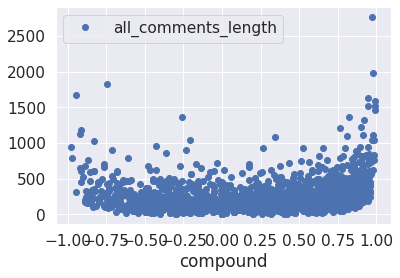

In [181]:
all_comments.plot(x='compound', y='all_comments_length', style='o')
sns.set_theme(color_codes=True)
#ax = sns.regplot(x="compound", y="all_comments_length", data=all_comments)

In [182]:
# get percentiles
all_comments['all_comments_length'].describe()

count    8964.000000
mean      138.279116
std       173.039452
min         1.000000
25%        41.000000
50%        85.000000
75%       172.000000
max      4284.000000
Name: all_comments_length, dtype: float64

count    8964.000000
mean      138.279116
std       173.039452
min         1.000000
25%        41.000000
50%        85.000000
75%       172.000000
max      4284.000000
Name: all_comments_length, dtype: float64

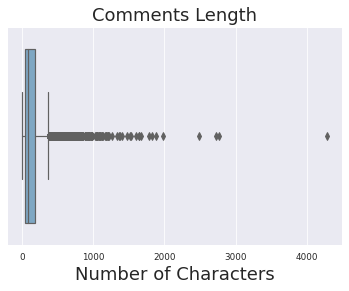

In [183]:
#boxplot of percentiles
sns.set_context("paper", rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":18}) 
boxplot = sns.boxplot(palette = "PuBu", x=all_comments['all_comments_length']).set(title = 'Comments Length', xlabel='Number of Characters')
all_comments['all_comments_length'].describe()

In [184]:
#get average length by sentiment class (see if "negative" comments are longer in length)
all_comments.groupby('Sentiment')['all_comments_length'].mean()
all_comments.groupby('Sentiment')['all_comments_length'].median()

Sentiment
neg    89.5
neu    53.0
pos    91.0
Name: all_comments_length, dtype: float64

In [185]:
# show comments with length > 500
all_comments[all_comments['Comment'].str.len() > 500]

Instance  \
25     AINST0201613   
165    AINST0202771   
321    AINST0203811   
616    AINST0205397   
678    AINST0205703   
...             ...   
17041  AINST0356328   
17108  AINST0357114   
18282  AINST0373272   
18570  AINST0377456   
18664  AINST0379011   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Comment  \
25                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Regarding  INC0760742:    I would like to have an action on your part to  please reverse the closeout process of the previously mentioned grants. They are all still active  (some of them for two years). I initiated the closeout process by mistake and now we at location location are afraid that if the grants remain in closeout status, one of the approving officers may accidentally approve the closeouts and end the grants prematurely. This would cause undue problems for us.  Can you please help us? Do you understand my concerns? Thank you very much.   
165    I had two issues:\n\n1.  the first issue was that I am logged into my main OpenNet account but am working overseas at location location.   I used the OpenNet MyProfile system to set my location to location, but apparently ILMS does not receive notifications of employee location, and continues to consider me as being in Washington.  This issue was partially resolved because I was told that in order to submit work orders for service in location I would have to transfer my MyServices account to location.   Instead, I will work from a TDY account here in location, which comes with a separate MyServices account.   This is inconvenient as I must login to a separate account to submit a work order.  It would be far preferable if the user could update MyServices to show their location, with the system then permitting submission of service requests at that location.  Since IRM already uses MyProfile to report user location, it should be possible for OpenNet

In [186]:
#getting count of pos, neg, neu by bucket size, to see at what length comments start going from being more positive to more negative

#create length buckets (eg. 50-99, 100-149, 150-199, etc.)
length_sentiment_df = pd.DataFrame(data=all_comments, columns=['all_comments_length', 'Sentiment'])
#bins = np.array([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 5000])

#quartile bins
bins = np.array([0, 41, 85, 172, 4284])

In [187]:
#see where negative count outpaces positive count (if ever)
#CONCLUSION: there is no length where there are more negative comments than positive
#bins = np.array([172, 272, 372, 472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472, 1572])

#test bucket assignments
length_sentiment_df["bucket"] = pd.cut(length_sentiment_df.all_comments_length, bins)
length_sentiment_df.head()

all_comments_length Sentiment       bucket
4                   187       neg  (172, 4284]
11                  239       pos  (172, 4284]
14                  463       neg  (172, 4284]
19                  423       pos  (172, 4284]
25                  553       pos  (172, 4284]

In [188]:
# get count of pos, neg and neu comments within each bucket                             
class_by_length = length_sentiment_df.groupby(['bucket'])['Sentiment'].value_counts()
class_by_length.head()

bucket    Sentiment
(0, 41]   neg           917
          pos           867
          neu           510
(41, 85]  pos          1049
          neg           890
Name: Sentiment, dtype: int64

# 11. Creating Seperate Data Frames for Positive, Neutral and Negative Sentiments 

In [189]:
# Create Seperate data frame for positive comments
all_pos_comments = all_comments[all_comments['Sentiment']=='pos']
all_pos_comments.count() # positive count = 6,041

Instance               4001
Comment                4001
Score                   694
compound                694
Sentiment              4001
all_comments_length    4001
dtype: int64

In [190]:
# Create seperate data frame for neutral comments
all_neu_comments = all_comments[all_comments['Sentiment']=='neu']
all_neu_comments.count() # neutral count = 2,066

Instance               1221
Comment                1221
Score                   254
compound                254
Sentiment              1221
all_comments_length    1221
dtype: int64

In [191]:
# Create seperate data frame for negative comments
all_neg_comments = all_comments[all_comments['Sentiment']=='neg']
all_neg_comments.count() # negative count = 857


Instance               3742
Comment                3742
Score                  1833
compound               1833
Sentiment              3742
all_comments_length    3742
dtype: int64

# 12. Data visualization

## Wordcloud for all comments combined

In [192]:
all_comments.head()

Instance  \
4   AINST0199999   
11  AINST0200492   
14  AINST0200647   
19  AINST0201374   
25  AINST0201613   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Comment  \
4                                                                                                                                                                                                                                                                                                                                                                                 On Sunday 9/29 I received another reminder that my password was expiring "in 1 day" even  after you updated the system to reflect my most recent password change of 9/16/19. Please advise.   
11                                                                                                                                                                                                                                                                                                                           ARIBA did not interface RFMS, for grant FA8678246. After PSU confirmed in RFMS that funds have not been obligated, PSU obligated funds manually in RFMS. Could you please double check the reason ARIBA did not interface RFMS for this grant.\n   
14                                                                                            I went into one of the file and while it will let me edit there is now no approval flow and it doesn't give me the choice to approve to closeout the award.  Just as a side note the website says that ILMS is a 24 hour service but when I called I was told Federal assistance isn't available and isn't actually 24 hours.  It is frustrating as I loss an entire day each time I open a ticket - if the website says 24 hours then why isn't actual assistance available?     
19                                                                                                                            According to the reply on 9/30/2019, could you please tell when it will be done. Thanks,\n\nHi Alex Chen,\n\nAs enhancement requests can take an extended amount of time, we have logged your request and it will be prioritized against all other enhancements for upcoming releases. Should you want a status update in the future, please submit a new incident and reference IS-92921 in the ticket.\n\nThank You,\nThe ILMS Support Desk\n   
25  Regarding  INC0760742:    I would like to have an action on your part to  please reverse the closeout process of the previously mentioned grants. They are all still active  (some of them for two years). I initiated the closeout process by mistake and now we at location location are afraid that if the grants remain in closeout status, one of the approving officers may accidentally approve the closeouts and end the grants prematurely. This would cause undue problems for us.  Can you please help us? Do you understand my concerns? Thank you very much.   

                                                             Score  compound  \
4     {'neg': 0.0, 'neu': 0.927, 'pos': 0.073, 'compound': 0.3182}    0.3182   
11     {'neg': 0.0, 'neu': 0.835, 'pos': 0.165, 'compound': 0.743}    0.7430   
14  {'neg': 0.093, 'neu': 0.86, 'pos': 0.047, 'compound': -0.6249}   -0.6249   
19    {'neg': 0.0, 'neu': 0.821, 'pos': 0.179, 'compound': 0.9001}    0.9001   
25     {'neg': 0.07, 'neu': 0.734, 'pos': 0.196, 'compound': 0.89}    0.8900   

   Sentiment  all_comments_length  
4  

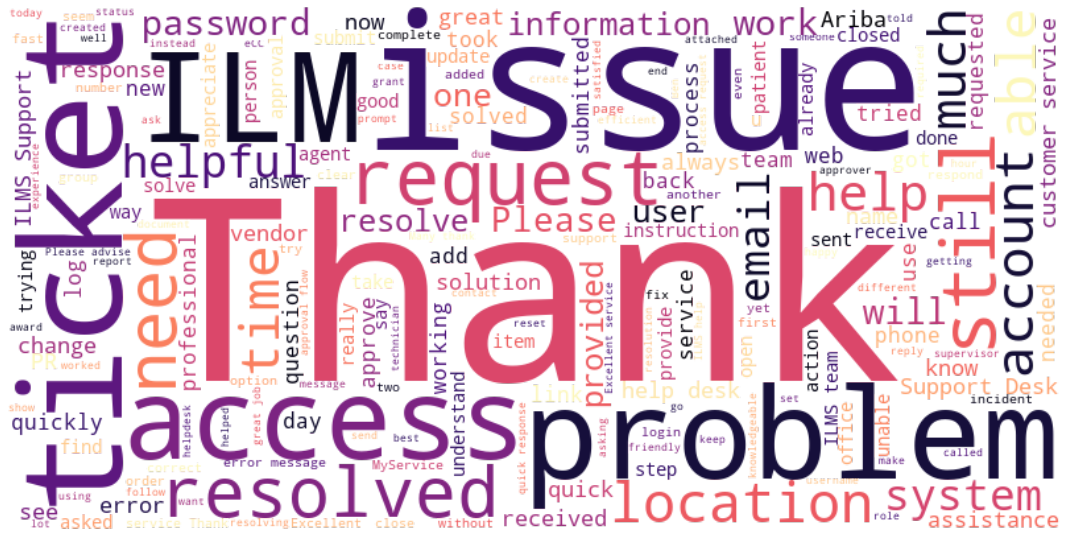

In [193]:
text = " ".join(review for review in all_comments["Comment"].astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS, mode = "RGBA", background_color=None, colormap="magma", width=800, height=400).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

## WordClouds for Unresolved, Management and Feedback Comments

In [194]:
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 155.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(30, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

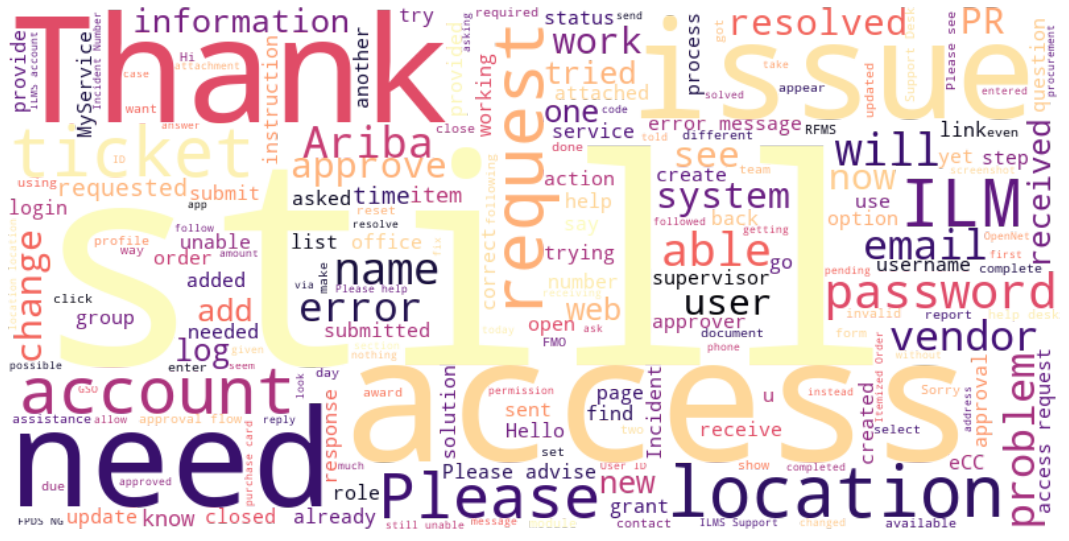

In [195]:
# Word Cloud on Unresolved Comments
from nltk import word_tokenize, sent_tokenize
text = " ".join(review for review in df_unresolved["Unresolved Comment"].astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS, mode = "RGBA", background_color=None, colormap="magma", width=800, height=400).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.savefig('Unresolved_wordcloud.png', transparent=True)
plt.show()

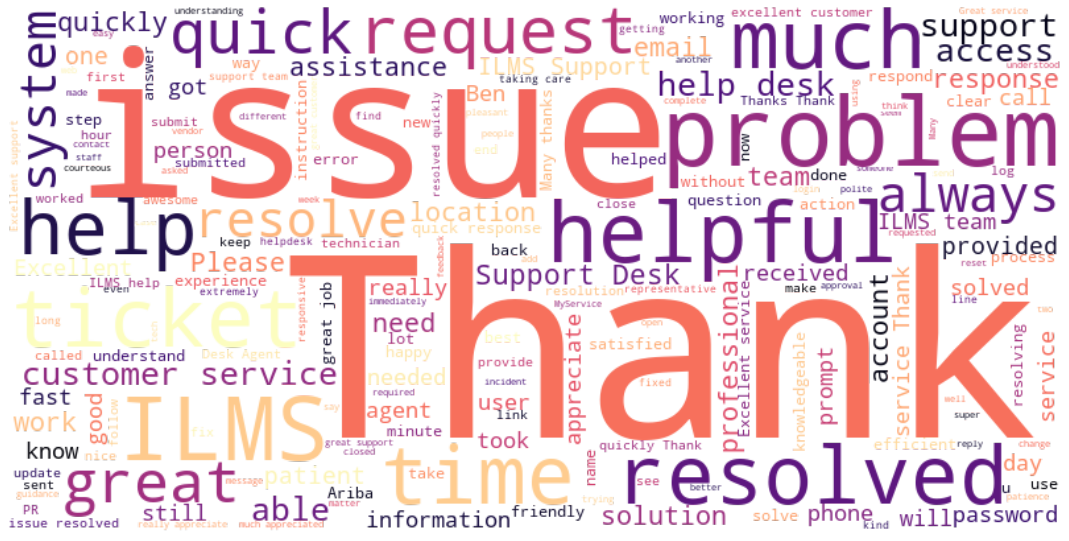

In [196]:
# WordCloud for Feedback: 
text = " ".join(review for review in df_feedback["Feedback"].astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS, mode = "RGBA", background_color=None, colormap="magma", width=800, height=400).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

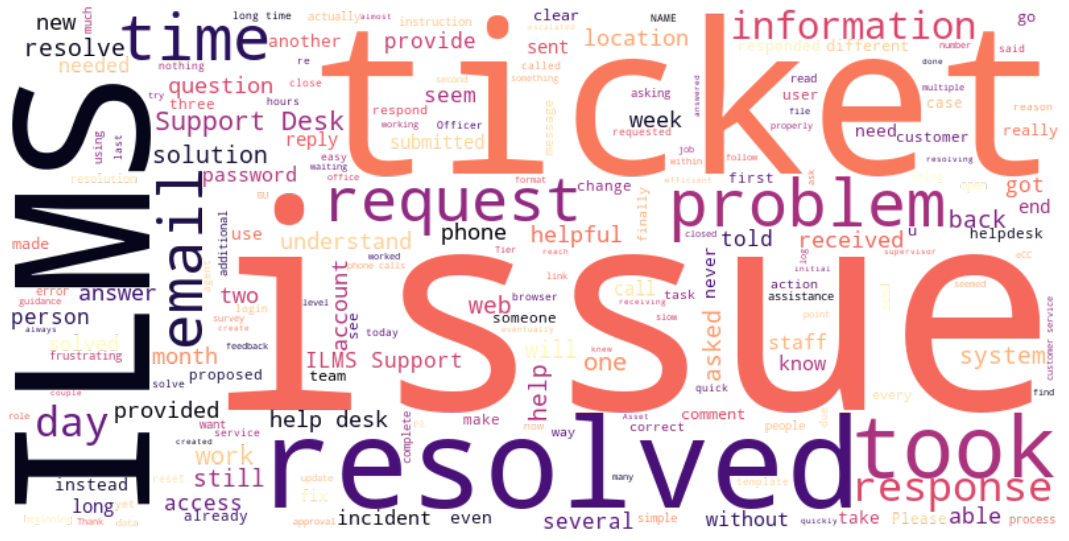

In [197]:
# WordCloud for Management Comments: 
text = " ".join(review for review in df_management["Management Comment"].astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS, mode = "RGBA", background_color=None, colormap="magma", width=800, height=400).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

## Word Cloud for Positive, Neutral and Negative Comments

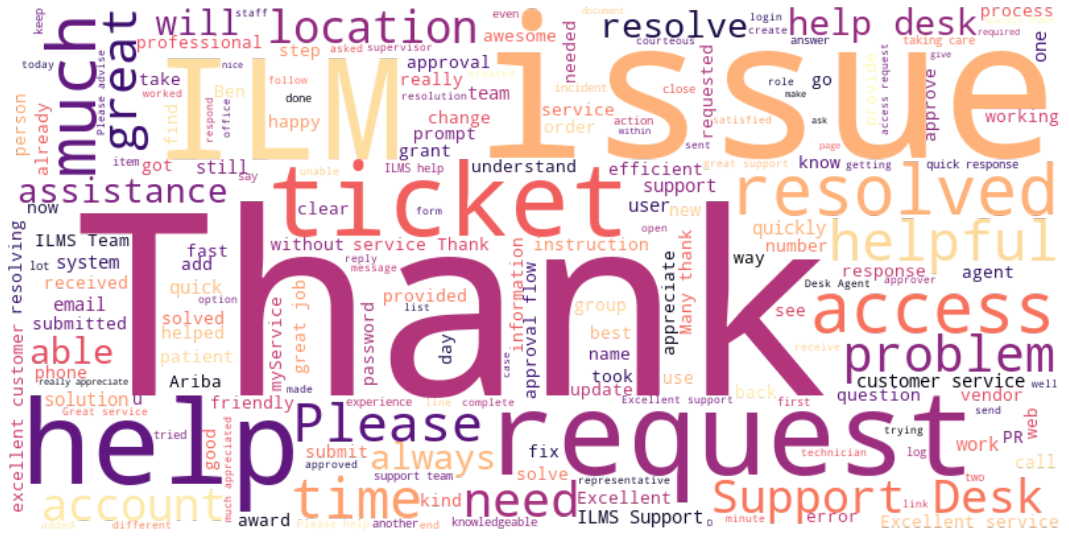

In [198]:
# Word Cloud for Positive Comment
text = " ".join(review for review in all_pos_comments["Comment"].astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS, mode = "RGBA", background_color=None, colormap="magma", width=800, height=400).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

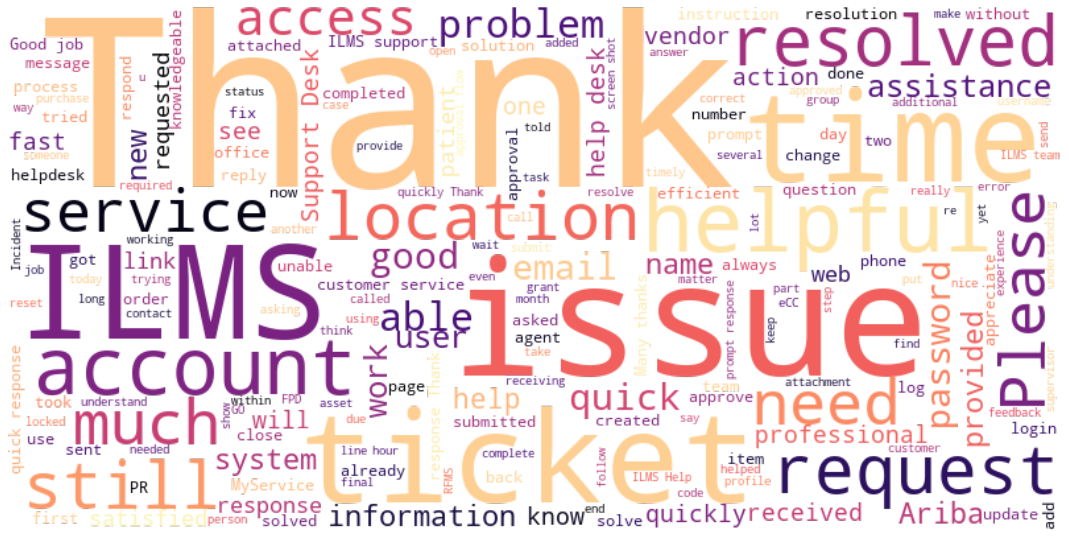

In [199]:
# Word Cloud for Neutral Comment
text = " ".join(review for review in all_neu_comments["Comment"].astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS, mode = "RGBA", background_color=None, colormap="magma", width=800, height=400).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

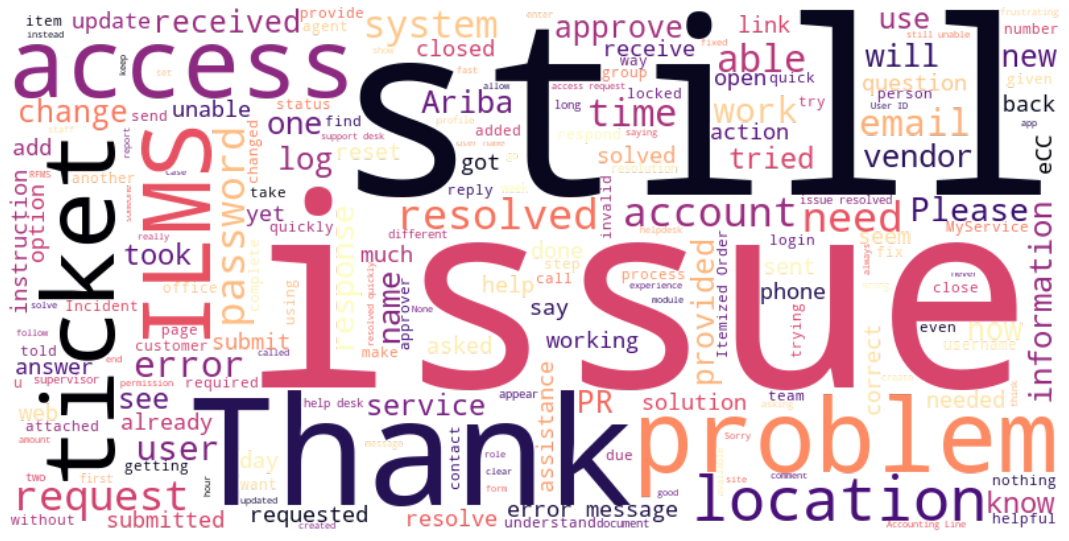

In [200]:
# Word Cloud for Negative Comment
text = " ".join(review for review in all_neg_comments["Comment"].astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS, mode = "RGBA", background_color=None, colormap="magma", width=800, height=400).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

## Bar Charts for Unresolved, Feedback and Mangement Comments

<AxesSubplot:title={'center':'Detected Sentiment of Management Comments'}>

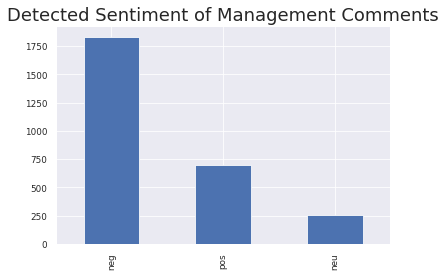

In [201]:

# Barchart showing sentiments for Unresolved Comments
df_unresolved['Sentiment'].value_counts().plot(kind='bar',title="Detected Sentiment of Management Comments")

<AxesSubplot:title={'center':'Detected Sentiment of Feedback Comments'}>

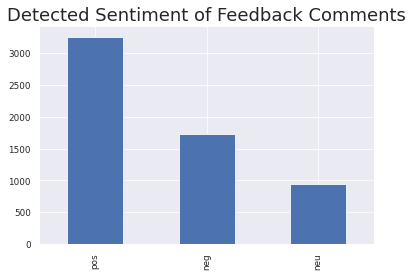

In [202]:
# Barchart showing sentiments for feedback Comments
df_feedback['Sentiment'].value_counts().plot(kind='bar',title="Detected Sentiment of Feedback Comments")

<AxesSubplot:title={'center':'Detected Sentiment of Management Comments'}>

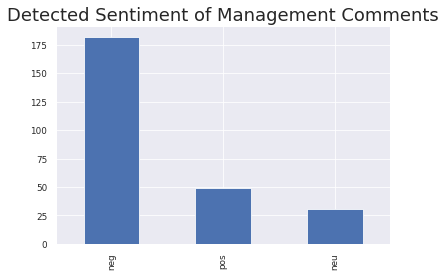

In [203]:
# Barchart showing sentiments for Management Comments
df_management['Sentiment'].value_counts().plot(kind='bar',title="Detected Sentiment of Management Comments")

## Bar Charts by Question Types

<AxesSubplot:title={'center':'Comment Types by Agent Satisfaction'}>

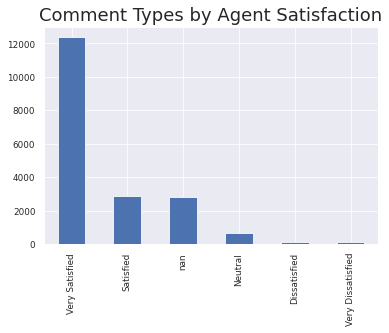

In [204]:
# By Agent Satisfaction
df_agensat = df_alldata.loc[df_alldata['Question']=='Agent Satisfaction',['Question','String Value']]
df_agensat = df_agensat['String Value'].value_counts(dropna = False)
df_agensat.plot(kind = "bar",title = "Comment Types by Agent Satisfaction")


Very Satisfied    12399
Satisfied          2869
NaN                2805
Neutral             628
Dissatisfied        147
Name: String Value, dtype: int64

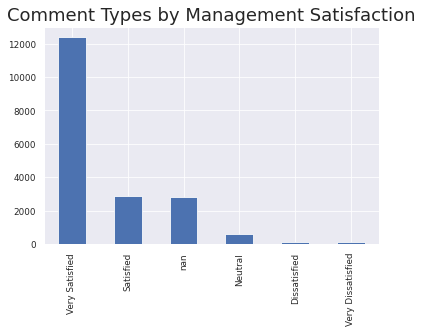

In [205]:
# By Management Satisfaction
df_mngsat = df_alldata.loc[df_alldata['Question']=='Management Satisfaction',['Question','String Value']]
df_mngsat = df_mngsat['String Value'].value_counts(dropna = False)
df_mngsat.plot(kind = "bar",title = "Comment Types by Management Satisfaction")
df_mngsat.head()

<AxesSubplot:title={'center':'Comment Types by Issue Resolved'}>

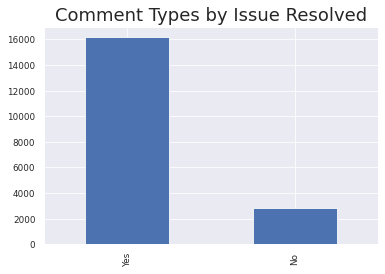

In [206]:
# By Issue Resolved
df_issres = df_alldata.loc[df_alldata['Question']=='Issue Resolved',['Question','String Value']]
df_issres = df_issres['String Value'].value_counts(dropna = False)
df_issres.plot(kind = "bar",title = "Comment Types by Issue Resolved")

## Correlation Plot

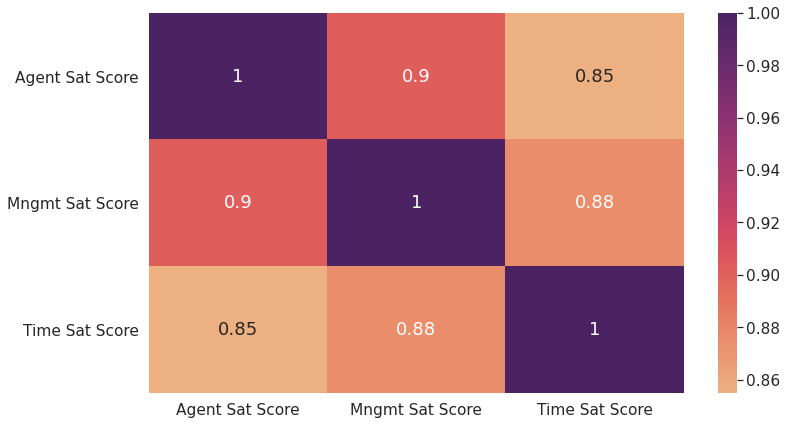

In [207]:
# correlation matrix of Agent Score, Mgmt Score and Time Score
corr_df = pd.DataFrame(df_clean, columns=['Agent Sat Score', 'Mngmt Sat Score', 'Time Sat Score'])
#corr_df = df5[['Agent Sat Score', 'Mngmt Sat Score', 'Time Sat Score']]
corr_df = corr_df.astype(float)
corrMatrix = corr_df.corr()
#print(corrMatrix)
sns.set(font_scale=1.4)
plt.figure(figsize = (12,7))
#sn.heatmap(corrMatrix, cmap=customPalette, annot=True, annot_kws={"size": 18})
sn.heatmap(corrMatrix, cmap="flare", annot=True, annot_kws={"size": 18})
plt.show()

## Quarter Wise Sentiment Analysis

In [220]:
df_timeanalysis = all_comments.merge(df_clean,how = 'inner', on = 'Instance')
df_quarter = df_timeanalysis.loc[df_timeanalysis['year']==2020,]
df_quarter = df_timeanalysis[['quarter','Sentiment']]
df_quarter= df_quarter.groupby(['quarter','Sentiment']).size().reset_index(name = 'Count')
df_quarter.head()

quarter Sentiment  Count
0        1       neg   1013
1        1       neu    322
2        1       pos   1023
3        2       neg    593
4        2       neu    271

In [221]:
df_quarter = df_quarter.groupby(['quarter','Sentiment']).size().reset_index(name = 'Count')

In [222]:
import plotly.express as px
fig = px.bar(df_quarter, x="quarter", y="Count", color="Sentiment", title="Long-Form Input")
fig.show()

## Month Wise Sentiment Analysis

In [223]:

df_timeanalysis['Month'] = df_timeanalysis['Month'].astype(str)
df_timeanalysis['Month']=df_timeanalysis.Month.str.pad(2,side='left',fillchar='0')
df_timeanalysis = df_timeanalysis.sort_values(by = 'Month')


In [224]:
import calendar

#df_timeanalysis['Month'] = df_timeanalysis['Month'].apply(lambda x: calendar.month_abbr[x])
df_timeanalysis['YearMonth'] = df_timeanalysis['year'].astype(str) + ' ' + df_timeanalysis['Month'].astype(str) 
df_timeanalysis = df_timeanalysis[['YearMonth','Sentiment']]
df_timeanalysis = df_timeanalysis.groupby(['YearMonth','Sentiment']).size().reset_index(name = 'Count')
df_timeanalysis.sort_values(by = 'YearMonth')
df_timeanalysis.head(20)

YearMonth Sentiment  Count
0    2019 10       neg    320
1    2019 10       neu     70
2    2019 10       pos    208
3    2019 11       neg    318
4    2019 11       neu     73
5    2019 11       pos    177
6    2019 12       neg    285
7    2019 12       neu     75
8    2019 12       pos    228
9    2020 01       neg    334
10   2020 01       neu     99
11   2020 01       pos    288
12   2020 02       neg    281
13   2020 02       neu     91
14   2020 02       pos    289
15   2020 03       neg    263
16   2020 03       neu     68
17   2020 03       pos    244
18   2020 04       neg    230
19   2020 04       neu     93

In [254]:
import plotly.express as px
import plotly.graph_objs as go

#fig = px.line(df_timeanalysis, x='YearMonth', y='Count', color='Sentiment', color_discrete_sequence=px.colors.qualitative.Vivid)
#fig = px.line(df_timeanalysis, x='YearMonth', y='Count', color='Sentiment', color_discrete_sequence=["DarkBlue", "DarkCyan", "DarkMagenta"])
#fig = px.line(df_timeanalysis, x='YearMonth', y='Count', color='Sentiment', color_discrete_sequence=px.colors.qualitative.Vivid, template="simple_white")
fig = px.line(df_timeanalysis, x='YearMonth', y='Count', color='Sentiment', color_discrete_sequence=["#00003d","#8e008b" ,"#ff8300"])
fig.update_layout(xaxis = go.layout.XAxis(tickangle = 45), 
        font=dict(
        family="Arial, monospace",
        size=16,
        color="black"
    ))

fig.show()
# color schemes: https://plotly.com/python/discrete-color/
# https://www.w3schools.com/cssref/css_colors.asp


In [234]:
fig.write_html("FIGURE.html")  # Save to HTML

# DASH server - DONT NEED THIS FOR NOW

In [215]:
pip install jupyter-dash #Dont need this for now

Note: you may need to restart the kernel to use updated packages.


In [216]:

from jupyter_dash import JupyterDash

#JupyterDash.infer_jupyter_proxy_config()

In [217]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px
import pandas as pd


external_stylesheets = ["https://codepen.io/chriddyp/pen/bWLwgP.css"]

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div(children = [
    dcc.Graph(id = "line-graph",
             figure =fig
             )
])


if __name__ == '__main__':
    app.run_server()

Dash app running on http://127.0.0.1:8050/


In [218]:
app.run_server(mode="jupyterlab")

# Common word pairings (bigrams, trigrams) 

In [219]:
#word pairings for unresolved comments

#unresolved_comments_tokenized = nltk.word_tokenize(New_data)
#nltk.download('punkt')

# unresolved_comments_tokenized = df5['Unresolved Comment'].apply(word_tokenize)
# unresolved_comments_bigrams = nltk.bigrams(unresolved_comments_tokenized)

# #compute frequency distribution for all the bigrams in the text
# fdist = nltk.FreqDist(unresolved_comments_bigrams)
# for k,v in fdist.items():
#     print(k,v)
    

# TF-IDF Vectorizer 

Below is the code for TF-IDF Vectorizer. The code still need some tweaks to work in a proper manner. Can be used as a reference for future developments

In [97]:
# Train on first 800 comments, then test on all 2771 comments

In [98]:

# import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')

In [99]:
# tf_train = New_data['Unresolved Comment'][0:800]

In [100]:
# tf_train = df_unresolved[0:800]

In [101]:
# tf_test = df_unresolved

In [102]:
# tfidfvectorizer = TfidfVectorizer(analyzer='word' , stop_words='english',)

In [103]:
# tfidfvectorizer.fit(tf_train)

In [104]:
# tfidf_train = tfidfvectorizer.transform(tf_train)

In [105]:
# tfidf_term_vectors = tfidfvectorizer.transform(tf_test)

In [106]:
# tfidf_term_vectors.todense()

In [107]:
# For first 5 Unresolved Comments, print the top 20 TF-IDF scores (separate training and testing) 
#    and the associated word (descending order)
# Comments separated by New Line

# for i in range(5):
#     test_vec = tfidf_term_vectors[i]
#     test_df = pd.DataFrame(test_vec.T.todense(), 
#                            index = tfidfvectorizer.get_feature_names(), 
#                            columns=["tfidf"])
#     print(test_df.sort_values(by=["tfidf"],ascending=False)[:20])
#     print('\n')

In [108]:
# all_comments.head()

In [109]:
# Tests and trains on all the comments at once
#tfidf_test2 = tfidfvectorizer.fit_transform(all_comments['Comment'])

In [110]:
# tfidf_test2.todense()

In [111]:
# tfidf_words_df = pd.DataFrame

In [112]:
# For first 5 Unresolved Comments, print the top 20 TF-IDF scores (train and test at once) 
#   and the associated word (descending order)
# Comments separated by New LineTF-IDF

# for i in range(5):
#     test_vec = tfidf_test2[i]
#     test_df = pd.DataFrame(test_vec.T.todense(), 
#                            index = tfidfvectorizer.get_feature_names(), 
#                            columns=["tfidf"])
#     print(test_df.sort_values(by=["tfidf"],ascending=False)[:20])
#     print('\n')

In [113]:
# tfidf_words_df = test_df.sort_values(by=["tfidf"],ascending=False).reset_index()
# tfidf_words_df = tfidf_words_df.rename(columns = {"index":"Words"})
# #df_unresolved.rename(columns = {"Unresolved Comment":"Comment"})
# tfidf_words_df.head(20)

In [114]:
# df = tfidf_words_df.head()
# fig = px.bar(df, x="tfidf", y= "Words", orientation='h')
# fig.update_layout( yaxis=dict(autorange="reversed"))
# fig.show()

In [115]:
# for i in range(len(all_comments)):
#     test_vec = tfidf_test2[i]
#     test_df = pd.DataFrame(test_vec.T.todense(), 
#                            index = tfidfvectorizer.get_feature_names(), 
#                            columns=["tfidf"])
# #    print(test_df.sort_values(by=["tfidf"],ascending=False)[:20])
# #    print('\n')
#     test_df.sort_values(by=["tfidf"],ascending=False)
    
#     for i in range(3):
#         print(tfidf_words_df['Words'] )
# #= test_df[i]
    

# Top words per cluster

The code still need some tweaks to work in a proper manner. Can be used as a reference for future developments

In [116]:
# from sklearn.feature_extraction.text import CountVectorizer
# count_vectorizer = CountVectorizer()

In [117]:
# .fit_transfer TOKENIZES and COUNTS
# X = count_vectorizer.fit_transform(tf_train)

In [118]:
# X.toarray()

In [119]:
# pd.DataFrame(X.toarray())

In [120]:
##What do all of those numbers mean????
# count_vectorizer.get_feature_names()

In [121]:
# from nltk.stem.porter import PorterStemmer
# porter_stemmer = PorterStemmer()

# def stemming_tokenizer(str_input):
#     words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
#     words = [porter_stemmer.stem(word) for word in words]
#     return words

# count_vectorizer = CountVectorizer(stop_words='english', tokenizer=stemming_tokenizer)
# X = count_vectorizer.fit_transform(tf_train)
# print(count_vectorizer.get_feature_names())

In [122]:
# from sklearn.feature_extraction.text import TfidfVectorizer

In [123]:
#value = (number of times word appears in sentence) / (number of words in sentence)
# tfidf_vectorizer = TfidfVectorizer(stop_words='english', tokenizer=stemming_tokenizer, use_idf=False, norm='l1')
# X = tfidf_vectorizer.fit_transform(tf_train)
# df8 = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names())
# df8

In [124]:
# KMeans clustering is a method of clustering.
# from sklearn.cluster import KMeans
# number_of_clusters = 2
# km = KMeans(n_clusters=number_of_clusters)
# km.fit(X)

In [125]:
# vectorizer.get_feature_names()

In [126]:
# Initialize a vectorizer
# vectorizer = TfidfVectorizer(use_idf=True, max_features=2, tokenizer=stemming_tokenizer, stop_words='english')
# X = vectorizer.fit_transform(tf_train)

In [127]:
# df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
# df

In [646]:
# ax = df.plot(kind='scatter', x='pleas', y='thi', alpha=0.1, s=300)
# ax.set_xlabel("pleas")
# ax.set_ylabel("thi")

In [647]:
# results = pd.DataFrame()
# results['text'] = tf_train
# results['category'] = km.labels_
# results

In [648]:
# number_of_clusters = 3
# km = KMeans(n_clusters=number_of_clusters)
# km.fit(X)
# df8['category'] = km.labels_
# df8

In [649]:
# print("Top terms per cluster:")
# order_centroids = km.cluster_centers_.argsort()[:, ::-1]
# terms = vectorizer.get_feature_names()
# for i in range(number_of_clusters):
#     top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
#     print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

In [650]:
# color_list = ['r', 'b', 'g', 'y']
# colors = [color_list[i] for i in df['category']]

# ax = df.plot(kind='scatter', x='pleas', y='thi', alpha=0.1, s=300, c=colors)
# ax.set_xlabel("pleas")
# ax.set_ylabel("thi")

In [651]:
# # Initialize a vectorizer
# vectorizer = TfidfVectorizer(use_idf=True, max_features=3, tokenizer=stemming_tokenizer, stop_words='english')
# X = vectorizer.fit_transform(tf_train)

In [652]:
# vectorizer.get_feature_names()

In [653]:
# df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
# df

In [654]:
# from sklearn.cluster import KMeans

# number_of_clusters = 4
# km = KMeans(n_clusters=number_of_clusters)
# km.fit(X)
# df['category'] = km.labels_

In [655]:
# df['text'] = tf_train
# df

In [656]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# def draw(ax, df):
#     color_list = ['r', 'b', 'g', 'y']
#     colors = [color_list[i] for i in df['category']]

#     marker_list = ['o', 'x', 'v', 'X']
#     markers = [marker_list[i] for i in df['category']]

#     ax.scatter(df8['pleas'], df8['thi'], df8['wa'], c=colors, s=100, alpha=0.5)
#     ax.set_xlabel('pleas')
#     ax.set_ylabel('thi')
#     ax.set_zlabel('wa')

# chart_count_vert = 5
# chart_count_horiz = 5
# number_of_graphs = chart_count_vert * chart_count_horiz

# fig = plt.figure(figsize=(3 * chart_count_horiz, 3 * chart_count_vert))

# for i in range(number_of_graphs):
#     ax = fig.add_subplot(chart_count_horiz, chart_count_vert, i + 1, projection='3d', azim=(-360 / number_of_graphs) * i)
#     draw(ax, df8)